# Прогнозирование оттока клиентов телеком компании

**Цель проекта:**  

Разработка модели модели машинного обучения для оператора связи «Ниединогоразрыва.ком», позволяющей прогнозировать отток клиентов.  
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.  
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Эффективность работы модели будет оцениваться метрикой ROC-AUC.  
Модель должна показать на тестовой выборке уровень метрики ROC-AUC не менее 0.85

**Описание услуг оператора**  

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic). 

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание предоставленных данных**

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре
- personal_new.csv — персональные данные клиента
- internet_new.csv — информация об интернет-услугах
- phone_new.csv — информация об услугах телефонии

Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

**План выполнения проекта:**

1. Загрузка библиотек и загрузка данных с первичным обзором
2. Предобработка данных
  - заполнение пропусков
  - коррекция типов данных
  - выявление и обработка аномалий
3. Объединение датафреймов
4. Исследование единого датафрейма
  - заполнение пропусков
  - создание новых признаков (при необходимости)
  - создание целевого признака
  - проверка признаков на мультиколлинеарность с использованием phik
5. Разделение данных на учебную и тестовую выборки в пропорции 3:1
6. Кодирование и масштабирование признаков 
7. Постройка и обучение на тестовой выборке с подбором гиперпараметров с кросс-валидацией нескольких моделей
  - LogisticRegression
  - RandomForestClassifier
  - CatBoostClassifier
8. Выбор лучшей модели на основе метрики ROC-AUC
9. Исследование лучшей модели
  - проверка качества лучшей модели на тестовой выборке 
  - проверка на адекватность
  - построение матрицы ошибок
  - исследование важности признаков лучшей модели.
10. Общий вывод

In [1]:
#pip install ydata-profiling
#pip install phik

In [2]:
import pandas as pd
from ydata_profiling import ProfileReport
import phik
from phik import resources, report
from phik import phik_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# для графического отображения результатов
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

RANDOM_STATE = 110923

### Загрузка библиотек и данных

In [3]:
# загрузка датафреймов (try - локально, except - по ссылке)
try:
    df_contract = pd.read_csv('datasets/contract_new.csv')
    df_personal = pd.read_csv('datasets/personal_new.csv')
    df_internet = pd.read_csv('datasets/internet_new.csv')
    df_phone = pd.read_csv('datasets/phone_new.csv')
    
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [4]:
df_contract.sample(40)

In [5]:
#report = ProfileReport(df_contract)
#report.to_file('data_report_contract_new.html')
#report.to_notebook_iframe()

In [6]:
df_personal

In [7]:
#report = ProfileReport(df_personal)
#report.to_file('data_report_personal_new.html')
#report.to_notebook_iframe()

In [8]:
df_internet

In [9]:
#report = ProfileReport(df_internet)
#report.to_file('data_report_internet_new.html')
#report.to_notebook_iframe()

In [10]:
df_phone

In [11]:
#report = ProfileReport(df_phone)
#report.to_file('data_report_phone_new.html')
#report.to_notebook_iframe()

**Вывод**

- У датафреймов разное количество строк (7043, 5517 и 6361)
- Названия признаков в виде слитных слов, разделенных прописной буквой (например, customerID). Нужно привести в змеиный вид (в виде customer_id)
- Пропусков нет
- Дубликатов нет
- Данные имеют как категориальное значение (например, PaperlessBilling, PaymentMethod), так и числовые значения (например признак MonthlyCharges, 29.85)
- Признак TotalCharges имеет тип данных object, однако, глядя на первые строки таблицы в этой колонке значения похожи на значения в колонке MonthlyCharges. Нужно выяснить в чем причина и привести данные к нужному формату. Данную рпоцедуру проведем в разделе 1.3 Подготовка данных для машинного обучения

### Объединение датафреймов

In [12]:
df_merged=pd.merge(df_contract,df_personal, how='outer')
df_merged=pd.merge(df_merged,df_phone, how='outer')
df_merged=pd.merge(df_merged,df_internet, how='outer')

# контроль результата

print(df_merged.shape)
print(df_merged.info())
display(df_merged.head())

### Предобработка данных

In [13]:
# Подсчет пропусков в каждом столбце
missing_values = df_merged.isnull().sum()

# Вывод результатов
print(missing_values)

In [14]:
df_merged = df_merged.fillna(value='Not_using')

In [15]:
# Подсчет пропусков в каждом столбце
missing_values = df_merged.isnull().sum()

# Вывод результатов
print(missing_values)

Переименуем столбцы змеиным стилем

In [16]:
# Создание словаря с новыми именами столбцов
new_column_names = {
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents',
    'MultipleLines': 'multiple_lines',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies',
}

# Переименование столбцов с помощью метода rename()
df_merged.rename(columns=new_column_names, inplace=True)

# Вывод обновленного датафрейма с переименованными столбцами
print(df_merged)

#### Создание целевого прзнака

Исходим из того, что если в дате окончаниия контракта стоит 'No', то клиент остался с оператором, а если присутствует конкретная дата, то ушёл.


In [17]:
# Создание нового признака на основе значения в столбце EndDate
df_merged['target_feature'] = df_merged['end_date'].apply(lambda x: 'No' if x == 'No' else 'Yes')

# Вывод обновленного датафрейма
display(df_merged.sample(20))

Приведем все столбцы к нижнему регистру

In [18]:
#df_merged.columns = df_merged.columns.str.lower()

Столбец 'TotalCharges' имеет неправильный тип 'object' вместо 'float64' и это нужно исправить перед анализом

In [19]:
#приведение данных в столбце 'TotalCharges' к типу 'float64'

df_merged['total_charges'] = pd.to_numeric(df_merged['total_charges'],errors='coerce')

#проверка результата

print(df_merged.info())

Создадим признак duration для отоброжения сколько дней клиент пользуется услугами компании 

Заменим значения 'No' в столбце 'end_date' в датафрейме на значение '2020-02-01', так как эта дата соответствует дате выгрузки данных.

In [20]:
df_merged['end_date'] = df_merged['end_date'].replace('No', '2020-02-01')

In [21]:
# Преобразуем столбцы в формат даты

df_merged['begin_date'] = pd.to_datetime(df_merged['begin_date'])
df_merged['end_date'] = pd.to_datetime(df_merged['end_date'])

# Создаем новый столбец с длительностью контракта в днях

df_merged['contract_days'] = (df_merged['end_date'] - df_merged['begin_date']).dt.days

print("Значения нового признака:",sorted(df_merged['contract_days'].unique())) 
display(df_merged.head())

Проверим пропуски

In [22]:
missing_values = df_merged.isnull().sum()

# Вывод количества пропущенных значений в каждом столбце
print(missing_values)

Посмотрим на строки с пропусками в признаке total_charges

In [23]:
# Вывод строк с пропусками в признаке total_charges
df_merged[df_merged['total_charges'].isnull()]

Во всех строках признака total_charges одна и та же дата - 01.02.2020г. и она совпадает с датой выгрузки датафреймов. Очевидно, что клиенты только заключили договор и они еще не оплачивали услуги связи. Такие пропуски заменим нулями

In [24]:
df_merged['total_charges'] = df_merged['total_charges'].fillna(0)

Проверим результат после заполнения всех пропусков

In [25]:
df_merged.isnull().sum().sort_values(ascending=False)

Удаление лишних признаков

Признаки на удаление:

- gender — пол клиента удалим, так как пользователей 50/50 мужчин/женщин
- begin_date и end_date — дата заключения / расторжения договора не окажет влияние на обучение моделей ML

In [26]:
# удаление признаков
df_merged = df_merged.drop(['customer_id', 'gender', 'begin_date', 'end_date'], axis = 1)

### Исследание признаков на мультиколлинеарность методом phik

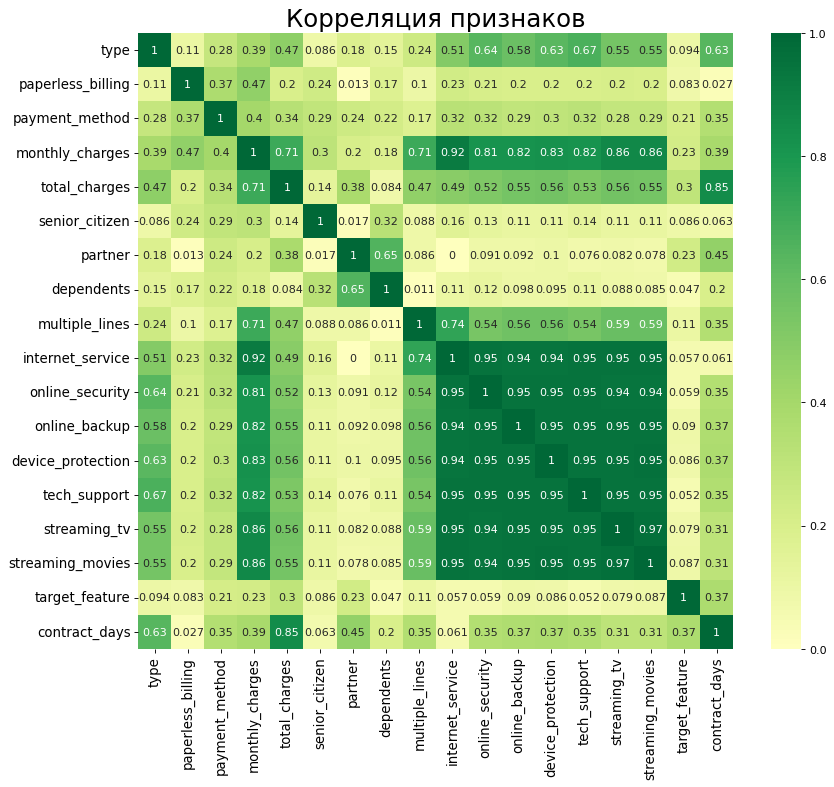

In [27]:
corr_matrix = phik_matrix(df_merged)

# вывод матрицы в виде Heatmap

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Вывод:
есть ряд признаков, очень сильно(с коэффициентом более 0.94) коррелирующих межу собой:
'InternetSerivice','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'.
Все эти признаки отражают пользование услугами, основанными на доступе к Интернет, следовательно их все можно удалить, оставив лишь признак 'InternetSerivice'.
Кроме того нужно удалить признак 'customerID' как бесполезный, равно как и 'gender'.

In [28]:
# удаление сильно кореллироющих между собой признаков

df_merged = df_merged.drop('online_security', axis=1)
df_merged = df_merged.drop('online_backup', axis=1)
df_merged = df_merged.drop('device_protection', axis=1)
df_merged = df_merged.drop('tech_support', axis=1)
df_merged = df_merged.drop('streaming_tv', axis=1)
df_merged = df_merged.drop('streaming_movies', axis=1)

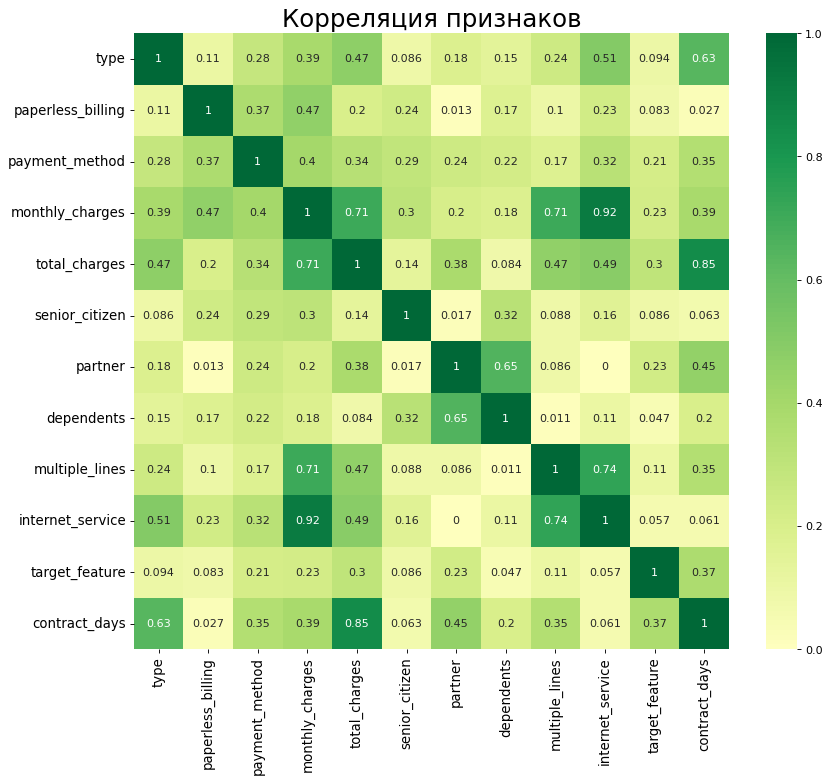

In [29]:
corr_matrix = phik_matrix(df_merged)

# вывод матрицы в виде Heatmap

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Вопросы
- Надо ли удалять столбец internet_service так как он сильно корелирует со столбцом total_charges? 
- Кореляцию выше кого числа стоит удалять (0.60, 0.70, 0.80, 0.90)?


Посмотрим на целевой признак на предмет дисбаланса классов

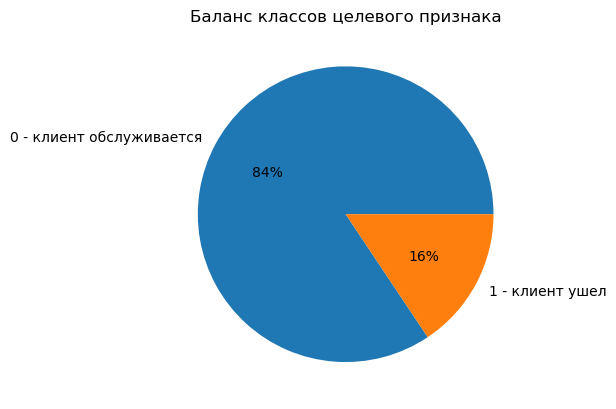

In [30]:
plt.pie(df_merged.target_feature.value_counts(), labels = ['0 - клиент обслуживается', '1 - клиент ушел'], autopct='%1.0f%%')
plt.title('Баланс классов целевого признака')

plt.show()

Дисбаланс классов есть. Это нужно учесть при подготовке данных для машинного обучения. Метрика AUC-ROC не чувствительна к дисбалансу классов, балансировать не нужно.

### Разделение данных на учебную и тестовую выборки

In [31]:
# формирование выборок с обучающими признаками и целевым признаком.

features = df_merged.drop(['target_feature'], axis=1)
target = df_merged['target_feature']

# разделение обучающей и валидационной выборки в пропорции 75:25.

features_train, features_test, target_train, target_test =\
    train_test_split(
    features,target,
    test_size=0.25, random_state=RANDOM_STATE)

#вывод размеров выборок для проверки

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

In [32]:
target_test

In [33]:
features_train

### Кодирование и масштабирование признаков

#### Масштабирование числовых признаков


In [34]:
# формируем список столбцов для масштабирования

numeric = ['monthly_charges', 'total_charges', 'contract_days']

# определение скейлера

scaler = StandardScaler() 

# настройка на обучающих данных

scaler.fit(features_train[numeric])

# масштабирование признаков тренировочной выборки 

features_train[numeric] = scaler.transform(features_train[numeric])

# масштабирование признаков тестовой выборки 

features_test[numeric] = scaler.transform(features_test[numeric])


 # контроль результата
    
display(features_train.head())
display(features_test.head())

### Кодирование категориальных признаков

In [35]:
#категориальные признаки для OHE Ridge

categorical_columns = features_train.select_dtypes(include='object').columns.to_list()
print(categorical_columns)

Кодирование признаков тренировочной выборки

In [36]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()
features_train_ohe.head()

In [37]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку

encoder_ohe = OneHotEncoder(drop='first', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки

encoder_ohe.fit(features_train_ohe[categorical_columns])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок

features_train_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_ohe[categorical_columns])

# удаляем незакодированные категориальные признаки (изначальные колонки)

features_train_ohe = features_train_ohe.drop(categorical_columns, axis=1)

# контроль результата
display(features_train_ohe.head())

In [38]:
target_test.replace({'No': 0, 'Yes': 1}, inplace=True)

Кодирование признаков тестовой выборки

In [39]:
# добавляем закодированные признаки в features_test_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок

features_test_ohe[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_test_ohe[categorical_columns])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_test_ohe = features_test_ohe.drop(categorical_columns, axis=1)

# контроль результата
display(features_test_ohe.head())

Вывод: числовые признаки масштабированы, категориальные - кодированы. Данные готовы к обучению моделей.

Постройка и обучение нескольких моделей
Будем оценивать качество обучения на тренировочной выборке с применением кросс-валидации и подбором гиперпараметров для трёх моделей, построенных на разных принципах:

- модели Логистической регрессии - это линейная модель классификации
- модели RandomForestClassifier - это модель классификации на основе деревьев
- модели CatBoostClassifier - это модель классификации на основе деревьев с применением градиентного бустинга

В результате будет выбрана лучшая модель, которая потом будет проверяться на тестовой выборке.

###  Обучение модели LogisticRegression

In [40]:
%%time

model_lr = LogisticRegression(random_state=RANDOM_STATE) 

# определение списка и диапазона гиперпараметров для подбора
grid_space = [{               
               'class_weight': [{0:1, 1:4}, {0:1, 1:6}, None]
             }]

# подбор параметров с кросс-валидацией
lr_grid = GridSearchCV(model_lr, 
                       param_grid=grid_space, 
                       cv=5, 
                       scoring='roc_auc', 
                       n_jobs=-1)

model_grid_lr = lr_grid.fit(features_train_ohe,target_train)

final_score_lr = model_grid_lr.best_score_

print('Гиперпараметры лучшей модели: '+str(model_grid_lr.best_params_))
print('Метрика ROC-AUC лучшей модели: '+str(final_score_lr))

In [41]:
%%time

model_forest = RandomForestClassifier(random_state=RANDOM_STATE) 

# определение списка и диапазона гиперпараметров для подбора
grid_space = [{
                'max_leaf_nodes': [100,150,200],
                'n_estimators': [250, 300, 350, 400, 450],
                'max_depth': [6, 10, 20]
               }]

# подбор параметров с кросс-валидацией
forest_grid = GridSearchCV(model_forest, 
                               param_grid=grid_space, 
                               cv=5, 
                               scoring='roc_auc', 
                               n_jobs=-1)
 
model_grid_forest = forest_grid.fit(features_train_ohe,target_train)   

final_score_forest = model_grid_forest.best_score_

       
print('Гиперпараметры лучшей модели: '+str(model_grid_forest.best_params_))
print('Метрика ROC-AUC лучшей модели: '+str(final_score_forest))

In [42]:
%%time

model_catboost = CatBoostClassifier(random_state=RANDOM_STATE) 

# определение списка и диапазона гиперпараметров для подбора
grid_space = [{'depth'         : [4,5,6],
               'learning_rate' : [0.1,0.13,0.15],
               'iterations'    : [400, 500, 600]
               }]

# подбор параметров с кросс-валидацией
cat_boost_grid = GridSearchCV(model_catboost, 
                               param_grid=grid_space, 
                               cv=5, 
                               scoring='roc_auc', 
                               n_jobs=-1)

model_grid_catboost = cat_boost_grid.fit(features_train_ohe,target_train)

final_score_catboost = model_grid_catboost.best_score_

print('Гиперпараметры лучшей модели: '+str(model_grid_catboost.best_params_))
print('Метрика ROC-AUC лучшей модели: '+str(final_score_catboost))

### Выбор лучшей модели на основе метрики ROC-AUC

Вывод: На основании обучения разных моделей по результатам оценки по метрике ROC-AUC лучшей моделью с показателем 0.92 выбрана модель CatBoost. Именно ее мы и будем исследовать в дальнейшем.

### Исследование лучшей модели

Проверка качества лучшей модели на тестовой выборке

In [43]:
probabilities_test = model_grid_catboost.predict_proba(features_test_ohe)
probabilities_one_test = probabilities_test[:, 1]

print("Лучшая модель, тестовая выборка, метрика ROC-AUC:")

print(roc_auc_score(target_test, probabilities_one_test))

In [44]:
y_pred = model_grid_catboost.predict(features_test_ohe)
y_pred_series = pd.Series(y_pred)
y_pred_series.replace({'No': 0, 'Yes': 1}, inplace=True)

# Преобразование обратно в массив NumPy
y_pred = y_pred_series.to_numpy()

accuracy = accuracy_score(target_test, y_pred)
print("Лучшая модель, тестовая выборка, метрика Accuracy:")
print(accuracy)

Вывод: Лучшая модель успешно показала уровень метрики ROC-AUC 0.93, что выше заданнного заказчиком порога 0.85.
Также модель показала хороший уровень метрики Accuracy = 0.92

In [45]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_test_ohe,target_test) # обучение модели на тренировочной выборке
predictions_dummy = dummy_clf.predict(features_test_ohe) # получение предсказания модели

print("Модель Dummy, тестовая выборка")

# определение качества модели Dummy на тестовой выборке
print("Accuracy:", accuracy_score(target_test, predictions_dummy))

Вывод: Лучшая модель показала результат Accuracy 0.92, что выше, чем 0.83 у модели Dummy. Следовательно лучшая модель прошла проверку на адекватность.

### Поcтроение ROC-кривой

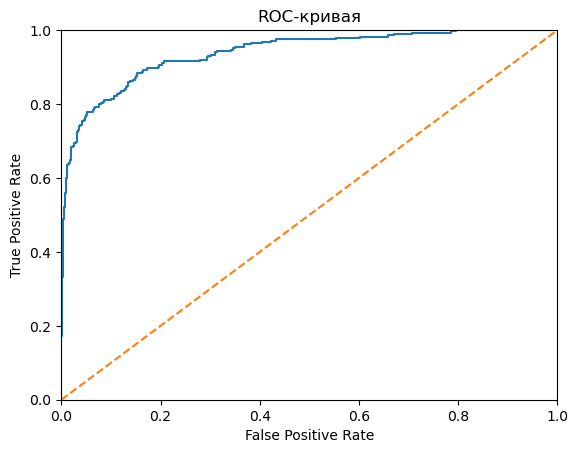

In [50]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Вывод: судя по ROC-кривой, модель дает результат предсказаний высокого качества.

### Construction of the error matrix

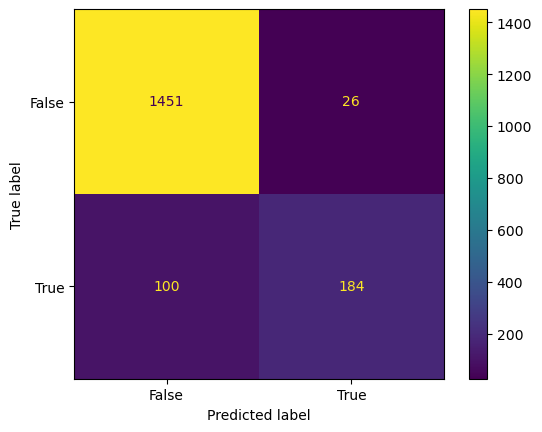

In [51]:
# Предсказание модели
predicted_test = model_grid_catboost.predict(features_test_ohe)

# Преобразование строковых предсказаний в числовые значения
label_encoder = LabelEncoder()
predicted_test_encoded = label_encoder.fit_transform(predicted_test)

# Вычисление confusion matrix
confusion_matrix = metrics.confusion_matrix(target_test, predicted_test_encoded)

# Отображение confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

**Вывод:** Матрица ошибок показывает высокое качество предсказания модели.

### Exploring the importance of attributes

In [52]:
feature_importance =  model_grid_catboost.best_estimator_.feature_importances_

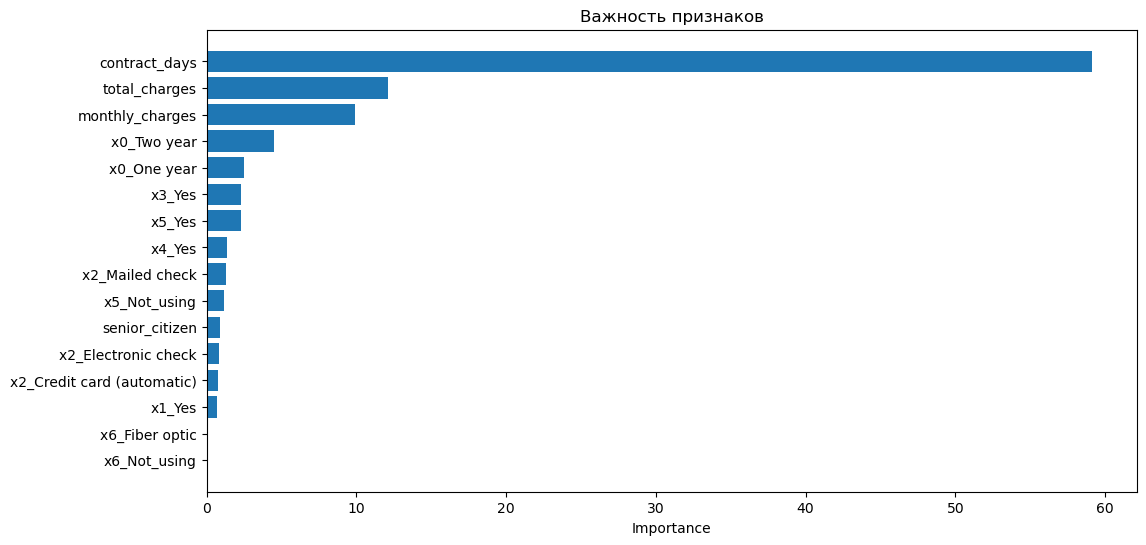

In [53]:
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test_ohe.columns)[sorted_idx])           
plt.title('Importance of attributes')
plt.xlabel('Importance')
plt.show()

Вывод: Наиболее важными признаками являются 'ContractDays', 'MonthlyCharges', 'TotalCharges'.

### Общий вывод

**В процессе выполнения проекта было проделано следующее:**

1. Загрузка библиотек и загрузка данных с первичным обзором
2. Предобработка данных
  - заполнение пропусков
  - коррекция типов данных
  - выявление и обработка аномалий
3. Объединение датафреймов
4. Исследование единого датафрейма
  - заполнение пропусков
  - создание новых признаков (при необходимости)
  - создание целевого признака
  - проверка признаков на мультиколлинеарность с использованием phik
5. Разделение данных на учебную и тестовую выборки в пропорции 3:1
6. Кодирование и масштабирование признаков 
7. Постройка и обучение на тестовой выборке с подбором гиперпараметров с кросс-валидацией нескольких моделей
  - LogisticRegression
  - RandomForestClassifier
  - CatBoostClassifier
8. Выбор лучшей модели на основе метрики ROC-AUC
9. Исследование лучшей модели
  - проверка качества лучшей модели на тестовой выборке 
  - проверка на адекватность
  - построение матрицы ошибок
  - исследование важности признаков лучшей модели.

**Результат обучения моделей:**

- Наилучшее качество по метрике ROC-AUC = 0.92 показала модель градиентного бустинга CatBoostClassifier с подобранными с использованием кросс-валидации гиперпараметрами, следовательно она и признана лучшей.

- Метрика ROC-AUC = 0.93 лучшей модели на тестовой выборке выше целевого уровня 0.85, следовательно модель удвлетворяет требованиям заказчика. Модель также показала высокое качество по метрике Accuracy = 0.92

- Гиперпараметры лучшей модели:
 - 'depth'= 4,
 - 'iterations' = 600, 
 - 'learning_rate' = 0.15

- Модель градиентного бустинга CatBoostClassifier прошла проверку на адекватность, показав результат по метрике Accuracy значительно лучше, чем метод DummyClassifier.

**Рекомендация сотрудникам оператора связи «Ниединогоразрыва.ком»:**
- Предлагается использовать разработанную в данном проекте модель на основе градиентного бустинга CatBoostClassifier с подобранными гиперпараметрами для прогнозирования оттока клиентов и, соответственно, оптимального применения промокодов и специальных условий для удержания клиентов.

### Отчёт по решению

В процессе выполнения проекта были выполнены все пункты изначального плана, а именно:
- Загрузка библиотек и загрузка данных с первичным обзором
- Предобработка данных
- Объединение датафреймов
- Исследование единого датафрейма
- Разделение данных на учебную и тестовую выборки
- Кодирование и масштабирование признаков
- Постройка и обучение на тестовой выборке с подбором гиперпараметров с кросс-валидацией нескольких моделей
- Выбор лучшей модели на основе метрики ROC-AUC
- Исследование лучшей модели

Для воспроизводимости результата следует отметить, что по указанию тимлида было выбрано следующее  значение глобальной константы: RANDOM_STATE = 280823

Главной трудностью на этапе обучения моделей являлся низкий показатель метрики ROC-AUC лучшей модели на тестовой выборке: не более 0.80 при целевом уровне 0.85, требуемом заказчиком, при том, что на обучении лучшая модель показывала вполне высокую метрику 0.94. Тимлид изначально инструктировала, что основные потенциальные проблемы скорее всего могут быть вызваны недостаточным качеством обработки признаков. После обращения к тимлиду были получены и выполнены указания по исправлению ошибок при создании нового признака, а также масштабировании и кодировании признаков. В частности, ключевым являлось то ,что  при кодированиии и масштабировании признаков тестовой выборки необходимо было использовать методы, обученные именно на тренировочной выборке, а не на тестовой, как мною делалось изначально. После внесенных исправлений нужный результат был получен: метрика ROC-AUC = 0.93, что существенно выше требуемого заказчиком уровня.

Ключевые шаги в решении задачи:
- Создание, обработка и отбор признаков для обучение моделей
- Обучение моделей и выбор лучшей модели
- Исследование лучшей модели

После анализа изначального набора признаков был исключен ряд признаков с высокой корреляцией между собой. Кроме того был создан новый признак длительности контракта в днях. Для исключения утечки были исключены из датасета признаки с датами. Также был исключен столбец customerID, не являющийся признаком. Был также создан целевой признак на основании даты окончания контракта. В результате иоговый список признаков состоял из следующего набора:
'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines','InternetService', 'ContractDays' (созданный новый признак), 'Churn' (созданный целевой признак).
Данный набор признаков составил разумный баланс между достаточностью информации для качественного обучения моделей с одной стороны и вычислительной нагрузкой, а следовательно и длительностью обучения с другой.

Числовые признаки были масштабированы методом StandardScaler().  
Категориальные признаки были кодированы методом OneHotEncoder(). 

Было проведено обучение на тренировочной выборке трёх моделей, построенных на разных принципах:

- модель Логистической регрессии - линейная модель классификации
- модель RandomForestClassifier - модель классификации на основе деревьев
- модель CatBoostClassifier - модель классификации на основе деревьев с применением градиентного бустинга

При обучении применялся подбор нескольких гиперпараметров с кросс-валидацией при помощи метода GridSearchCV()  
В результате лучшей была выбрана модель CatBoostClassifier, которая показала уровень метрики ROC-AUC = 0.92 на тренировочной выборке со следующим набором гиперпараметров:
 - 'depth'= 4,
 - 'iterations' = 600, 
 - 'learning_rate' = 0.15
 
На тестовой выборке лучшая модель с данными гиперпараметрами показала уровень метрики ROC-AUC = 0.93 выше целевого уровня 0.85, удовлетворяющего требования заказчика. 
Высокое качество модели было подтверждено метрикой Accuracy = 0.92.  

- Cогласно ROC-кривой, модель дает результат предсказаний высокого качества.
- Матрица ошибок также подтверждает высокое качество предсказания модели.
- Была исследована важность признаков лучшей модели и были выявлены самые важные признаки: 'ContractDays', 'MonthlyCharges', 'TotalCharges'

Лучшая модель прошла проверку на адекватность, показав результат по метрике Accuracy значительно лучше, чем метод DummyClassifier.

В результате выполнения проекта сотрудникам оператора связи предлагается использовать разработанную в данном проекте модель на основе градиентного бустинга CatBoostClassifier с подобранными гиперпараметрами для прогнозирования оттока клиентов и, соответственно, оптимального применения промокодов и специальных условий для удержания клиентов.